# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
!pip install scikit-learn==0.24.2

In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

#добавил библиотеку time для оценки времени обучения и предсказания моделей
import time

In [ ]:
df = pd.read_csv('/datasets/autos.csv')
df_old = df

In [ ]:
display(df.head(5))
print('-----------------------------------------------------------------')

display(df.info())
print('-----------------------------------------------------------------')

display(df.describe())
print('-----------------------------------------------------------------')

print('Кол-во пропусков:')
display(df.isna().sum())
print('-----------------------------------------------------------------')

print('Кол-во дубликатов -', df.duplicated().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  La

None

-----------------------------------------------------------------


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


-----------------------------------------------------------------
Кол-во пропусков:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

-----------------------------------------------------------------
Кол-во дубликатов - 4


**Выводы по разделу 1. Подготовка данных**

1. Есть признаки, которые никак не влияют на цену - DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen. От них надо избавиться
2. В признаках, влияющих на цену, есть пропуски
3. В целевом признаке и признаке Power есть 0, наверняка есть другие выбросы
4. В RegistrationYear указан минимальный год 1000, наверняка есть другие выбросы
5. Есть дубликаты, от которых также надо избавиться
6. В названиях признаков надо избавиться от верблюжьего стиля
7. В признаках Gearbox и NotRepaired значения можно заменить на 1/0

### Предобработка данных

In [ ]:
#перевожу названия в змеиный стиль:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [ ]:
#избавляюсь от дубликатов:
df.drop_duplicates(inplace=True)

In [ ]:
#избавляюсь от признаков, не влияющих на целевой признак:
df.drop(columns=['date_crawled', 'date_created', 'number_of_pictures',
                    'postal_code', 'last_seen', 'registration_month'],
           axis=1,
           inplace=True)

#### Целевой признак price

In [ ]:
#смотрю, сколько нулей в целевом признаке:
df['price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

In [ ]:
#удаляю все 0 из целевого признака:
df = df.query('price > 0')

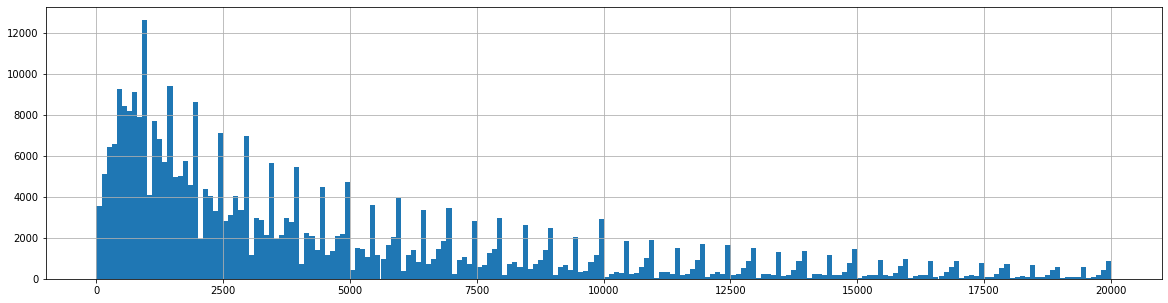

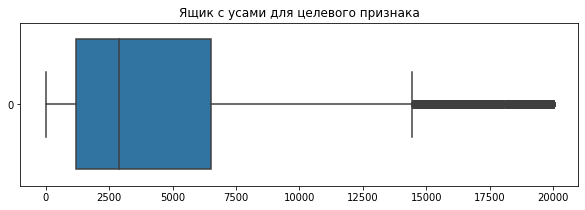

In [ ]:
#смотрю гистограмму и ящик с усами для целевого признака:
df['price'].hist(bins=200, figsize=(20,5))

plt.figure(figsize=(10,3))
sns.boxplot(data=df.price, orient='h')
plt.title('Ящик с усами для целевого признака')
plt.show()

In [ ]:
#поскольку на гистограмме и ящике с усами странные данные у нуля и длинный хвост возле 15000, смотрю квантили:
df['price'].quantile([.05, 0.95])

0.05      350.0
0.95    14800.0
Name: price, dtype: float64

In [ ]:
#смотрю долю строк, где цена меньше 350 и больше 14800:
1 - df.query('350 <= price <= 14800').shape[0] / df.shape[0]

0.09517365021988222

In [ ]:
#избавляюсь от 10% строк, где цена меньше 350 и больше 14800:
df = df.query('350 <= price <= 14800')

#### Признак registration_year

In [ ]:
#смотрю значения в registration_year:
df['registration_year'].value_counts()

2000    20907
2005    20811
1999    20621
2003    19217
2001    19091
        ...  
1948        1
1949        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 130, dtype: int64

In [ ]:
annual = df.pivot_table(index='registration_year', values='brand', aggfunc='count')
annual.columns = ['quantity']
annual

,quantity
registration_year,
1000,18
1001,1
1039,1
1111,1
1234,2
...,...
8500,1
8888,1
9000,2


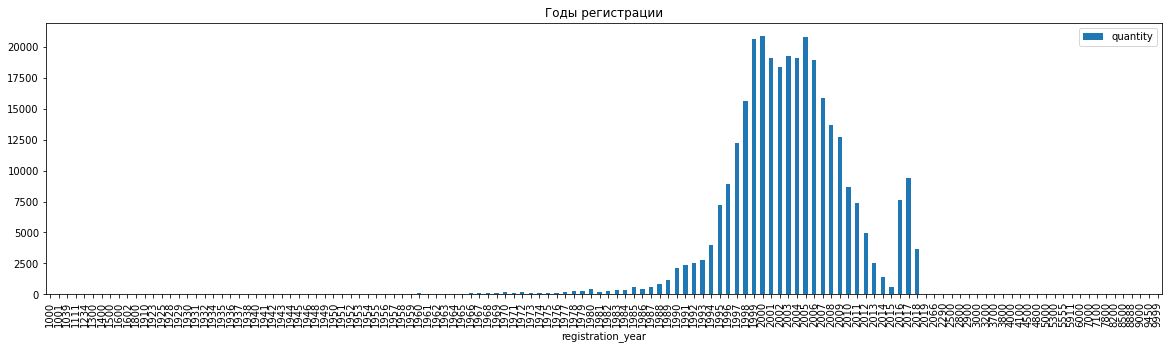

In [ ]:
#смотрю график для registrationyear:
annual.plot.bar(figsize = (20,5))
plt.title('Годы регистрации')
plt.show()

In [ ]:
#смотрю самый поздний год выгрузки:
df_ = pd.read_csv('/datasets/autos.csv')
df_.DateCrawled.max()

'2016-04-07 14:36:58'

In [ ]:
#допускаю, что автомобиле до 1975 и позже 2016 годов (органичение данных) были поставлены на учет и на продажу
#поэтому оставляю в таблице только годы регистрации с 1975 по 2016:
df = df.query('1975 <= registration_year <= 2016')

#### Признак power

In [ ]:
#смотрю значения в power:
df['power'].value_counts()

0        26795
75       20640
60       13045
150      13008
101      12106
         ...  
1082         1
1079         1
1703         1
2729         1
17019        1
Name: power, Length: 627, dtype: int64

<AxesSubplot:>

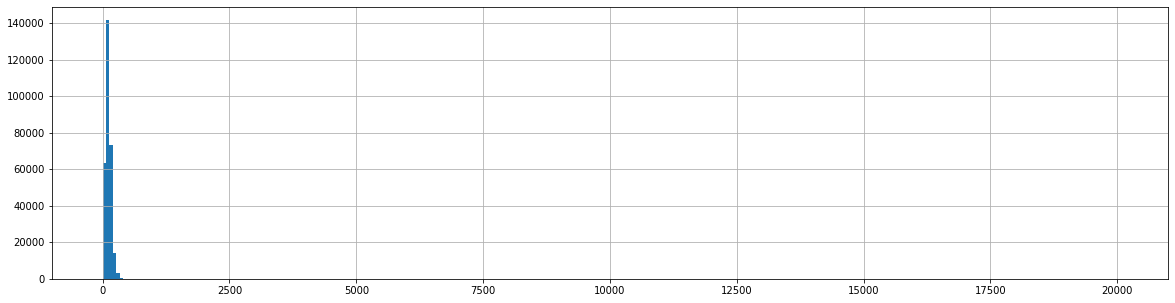

In [ ]:
#смотрю гистограмму power:
df['power'].hist(bins=300, figsize=(20,5))

In [ ]:
df['power'].describe()

count    296131.000000
mean        111.028275
std         184.505329
min           0.000000
25%          75.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64

In [ ]:
#самый мощный автомобиль был представлен компанией Automobili Pininfarina, модель Battista мощностью 1900 л.с.
#в рамках Женевского автошоу 2019 года, посмотрим, что в предоставленной базе
df.loc[df['power'] > 1900]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,NaN
19092,9750,wagon,2005,auto,2729,5er,150000,gasoline,bmw,no
22281,3999,sedan,1998,manual,1993,3er,150000,cng,bmw,NaN
25232,10900,bus,2009,manual,10520,caddy,150000,gasoline,volkswagen,no
33952,3740,small,2006,manual,6920,aygo,90000,NaN,toyota,no
...,...,...,...,...,...,...,...,...,...,...
341320,1899,other,2006,manual,7518,berlingo,125000,petrol,citroen,yes
346639,1300,sedan,2000,manual,12512,carisma,150000,petrol,mitsubishi,NaN
348137,850,sedan,1993,auto,9012,golf,150000,petrol,volkswagen,NaN
348237,3000,coupe,2007,manual,2007,corsa,150000,gasoline,opel,yes


In [ ]:
#самым маломощным автомобилем является Citroen 2CV с силой мотора 9 л.с.
df.loc[df['power'] < 9]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,NaN,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes
69,1200,coupe,2001,NaN,0,astra,150000,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
354336,3299,NaN,2005,auto,0,outlander,150000,petrol,mitsubishi,NaN
354346,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354360,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no


In [ ]:
#то выкину из таблицы всё, что выше и ниже этих границ:
df = df.query('9 <= power <= 1900')

<AxesSubplot:>

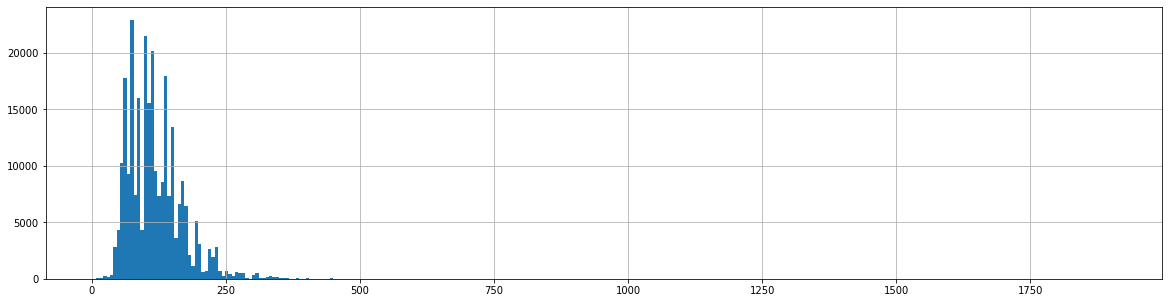

In [ ]:
df['power'].hist(bins=300, figsize=(20,5))

#### Признак kilometer

In [ ]:
#смотрю значения в kilometer:
df['kilometer'].value_counts()

150000    183658
125000     29148
100000     11366
90000       9039
80000       7752
70000       6540
60000       5584
50000       4453
40000       3437
30000       2906
20000       2331
5000        2251
10000        580
Name: kilometer, dtype: int64

В признаке kilometer выбросов нет и аномалий нет

#### Признак brand

In [ ]:
df['brand'].value_counts()

volkswagen        58357
opel              29863
bmw               28890
mercedes_benz     24463
audi              22566
ford              18502
renault           12930
peugeot            8945
fiat               7019
seat               5414
skoda              4583
smart              4449
mazda              4446
citroen            4009
toyota             3855
nissan             3602
hyundai            2887
volvo              2564
mini               2492
mitsubishi         2286
honda              2270
kia                1912
suzuki             1848
alfa_romeo         1846
chevrolet          1348
sonstige_autos     1225
chrysler           1093
dacia               785
subaru              571
daihatsu            557
jeep                494
saab                444
porsche             390
jaguar              372
daewoo              366
land_rover          362
lancia              340
rover               327
trabant             222
lada                151
Name: brand, dtype: int64

В признаке brand неявных дубликатов нет

#### Признак gearbox

In [ ]:
#заменяю NaN на 'manual':
df.fillna({'gearbox':'manual'}, inplace=True)

In [ ]:
#заменяю в gearbox значение manual на 1, auto - на 0:
df.loc[(df.gearbox == 'manual'), 'gearbox'] = 1
df.loc[(df.gearbox == 'auto'), 'gearbox'] = 0

In [ ]:
df.gearbox = df.gearbox.astype('int')

#### Признак repaired

In [ ]:
#заменяю NaN на 'yes', вероятнее всего,
#что поддержанная машина была в ремонте и продавец решил это в объявлении не указать, чем обратное
df.fillna({'repaired':'yes'}, inplace=True)

In [ ]:
#заменяю в repaired значение yes на 1, no - на 0:
df.loc[(df.repaired == 'yes'), 'repaired'] = 1
df.loc[(df.repaired == 'no'), 'repaired'] = 0

In [ ]:
df['repaired'] = df['repaired'].astype('int')

#### Признак model

In [ ]:
#заменяю NaN на 'unknown':
df.fillna({'model':'unknown'}, inplace=True)
df['model'].value_counts()

golf                  22615
other                 17964
3er                   16109
polo                   9730
unknown                9546
                      ...  
serie_2                   2
range_rover_evoque        2
gl                        2
serie_3                   1
rangerover                1
Name: model, Length: 250, dtype: int64

#### Признак vehicletype

In [ ]:
#заменяю пропуски на unknown:
df.fillna({'vehicle_type':'unknown'}, inplace=True)
df['vehicle_type'].value_counts()

sedan          76367
small          64639
wagon          54757
bus            24456
convertible    16423
coupe          12314
unknown         9209
suv             8688
other           2192
Name: vehicle_type, dtype: int64

#### Признак fueltype

In [ ]:
df.fillna({'fuel_type':'unknown'}, inplace=True)
df['fuel_type'].value_counts()

petrol      171669
gasoline     78647
unknown      13460
lpg           4527
cng            467
hybrid         154
other           66
electric        55
Name: fuel_type, dtype: int64

**Посмотрим итоговое состояние базы данных**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269045 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              269045 non-null  int64 
 1   vehicle_type       269045 non-null  object
 2   registration_year  269045 non-null  int64 
 3   gearbox            269045 non-null  int64 
 4   power              269045 non-null  int64 
 5   model              269045 non-null  object
 6   kilometer          269045 non-null  int64 
 7   fuel_type          269045 non-null  object
 8   brand              269045 non-null  object
 9   repaired           269045 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 22.6+ MB


In [ ]:
#смотрю на % сохраненных данных в датафрейме, после предобработки
print("База данных, после предобработки, сохранена на", len(df['price'])/len(df_old['price']) * 100, "%")
print("Количество отброшенных данных:", (len(df_old) - len(df)))

База данных, после предобработки, сохранена на 75.92313010596419 %
Количество отброшенных данных: 85320


**Выводы по разделу 1.1 Предобработка данных:**

1. Избавился от:
    - признаков, которые никак не влияют на целевой признак
    - верблюжьего стиля
    - дубликатов
    - выбросов в целевом признаке и признаках
    

2. Заполнил пропуски в:
    - gearbox значением 'manual', и заменила значения на 1/0
    - notrepaired значением 'yes', и заменила значения на 1/0
    - model, vehicletype, fueltype значением 'unknown'
    

3. В целом цена логично зависит:
    - прямо пропорционально от года регистрации, мощности
    - обратно пропорционально от пробега, ремонта, типа коробки
    

В результате обработки данных датафрейм сократился на 24,9%, однако данных, в количестве 269045, достаточно для обучения моделей

## Обучение моделей

In [ ]:
#выделяю признаки и целевой признак:
features_orig = df.drop('price', axis=1)
target = df.price

Перед обучением модели разделил выборки на обучающую, тестовую и валидационную


In [ ]:
#разделяю данные на обучающую и тест-валидационную выборки в соотношении 60/40:
features_train, features_test_valid, target_train, target_test_valid = train_test_split(features_orig,
                                                                                            target,
                                                                                            test_size=.4,
                                                                                            shuffle=True,
                                                                                            random_state=12345)

#разделяю тест-валидационную выборку на валидационную и тестовую в соотношении 20/20:
features_test, features_valid, target_test, target_valid = train_test_split(features_test_valid,
                                                                                            target_test_valid,
                                                                                            test_size=0.5,
                                                                                            shuffle=True,
                                                                                            random_state=12345)

In [ ]:
for i in [features_train, features_test, features_valid, target_train, target_test, target_valid]:
    print(i.shape)

(161427, 9)
(53809, 9)
(53809, 9)
(161427,)
(53809,)
(53809,)


In [ ]:
#выбор категориальных признаков
cat_features = ['vehicle_type', 'fuel_type', 'brand', 'model']

#создание экземпляра OneHotEncoder
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

#обучение кодировщика на обучающих данных
encoder_ohe.fit(features_train[cat_features])

#преобразование признаков для обучающей, тестовой и валидационной выборок
features_train_ohe = pd.DataFrame(encoder_ohe.transform(features_train[cat_features]),
                                  columns=encoder_ohe.get_feature_names(cat_features),
                                  index=features_train.index)

features_test_ohe = pd.DataFrame(encoder_ohe.transform(features_test[cat_features]),
                                 columns=encoder_ohe.get_feature_names(cat_features),
                                 index=features_test.index)

features_valid_ohe = pd.DataFrame(encoder_ohe.transform(features_valid[cat_features]),
                                  columns=encoder_ohe.get_feature_names(cat_features),
                                  index=features_valid.index)

#копирование целевой переменной
target_train_ohe = target_train.copy()
target_test_ohe = target_test.copy()
target_valid_ohe = target_valid.copy()

In [ ]:
#создаем экземпляр класса OrdinalEncoder
encoder_OE = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

#выбираем категориальные признаки
categorical_features = ['vehicle_type', 'fuel_type', 'brand', 'model']

#обучаем кодировщик на обучающих данных
encoder_OE.fit(features_train[categorical_features])

#создаем копии обучающей, тестовой и валидационной выборок
features_train_oe = features_train.copy()
features_test_oe = features_test.copy()
features_valid_oe = features_valid.copy()

#заменяем значения категориальных признаков на их числовые представления с помощью метода transform()
features_train_oe[categorical_features] = encoder_OE.transform(features_train[categorical_features])
features_test_oe[categorical_features] = encoder_OE.transform(features_test[categorical_features])
features_valid_oe[categorical_features] = encoder_OE.transform(features_valid[categorical_features])

#создаем копии целевых переменных
target_train_oe = target_train.copy()
target_test_oe = target_test.copy()
target_valid_oe = target_valid.copy()

In [ ]:
#смотрю размеры выборок:
for i in [features_train_ohe, features_test_ohe, features_valid_ohe, target_train_ohe, target_test_ohe, target_valid_ohe]:
    print(i.shape)

print()

for i in [features_train_oe, features_test_oe, features_valid_oe, target_train_oe, target_test_oe, target_valid_oe]:
    print(i.shape)

print()

for i in [features_train, features_test, features_valid, target_train, target_test, target_valid]:
    print(i.shape)

(161427, 306)
(53809, 306)
(53809, 306)
(161427,)
(53809,)
(53809,)

(161427, 9)
(53809, 9)
(53809, 9)
(161427,)
(53809,)
(53809,)

(161427, 9)
(53809, 9)
(53809, 9)
(161427,)
(53809,)
(53809,)


### Модель LinearRegression

#### На выборках c OneHotEncoder

In [ ]:
#%%time

start_time = time.time()

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train_ohe)

end_time = time.time()

training_time_lr_ohe = end_time - start_time
print("Время обучения модели:", training_time_lr_ohe)

Время обучения модели: 49.70911145210266


In [ ]:
#%%time

start_time = time.time()

target_predict = model_lr.predict(features_test_ohe)

end_time = time.time()

predict_time_lr_ohe = end_time - start_time
print("Время предсказания модели:", predict_time_lr_ohe)

Время предсказания модели: 0.10733437538146973


In [ ]:
rmse_lr_ohe = mean_squared_error(target_test_ohe, target_predict) ** .5
rmse_lr_ohe

7018159316.908478

#### На выборках c OrdinalEncoder

In [ ]:
#%%time

start_time = time.time()

model_lr = LinearRegression()
model_lr.fit(features_train_oe, target_train_oe)

end_time = time.time()

training_time_lr_oe = end_time - start_time
print("Время обучения модели:", training_time_lr_oe)

Время обучения модели: 0.07681679725646973


In [ ]:
#%%time

start_time = time.time()

target_predict = model_lr.predict(features_train_oe)

end_time = time.time()

predict_time_lr_oe = end_time - start_time
print("Время предсказания модели:", predict_time_lr_oe)

Время предсказания модели: 0.007597684860229492


In [ ]:
rmse_lr_oe = mean_squared_error(target_train_oe, target_predict) ** .5
rmse_lr_oe

2456.8981286237786

#### C использованием кроссвалидации

In [ ]:
#%%time

start_time = time.time()

model_lr = LinearRegression()

#что бы уйти от отрицательных значений массива, произвожу умножений на -1
cvs_rmse_lr = (cross_val_score(model_lr,
                               features_train_ohe,
                               target_train_ohe,
                               cv=5,
                               scoring='neg_mean_squared_error')).mean() * -1 ** .5

end_time = time.time()

training_time_lr_cross_ohe = end_time - start_time
print("Время обучения модели:", training_time_lr_cross_ohe)

cvs_rmse_lr

Время обучения модели: 161.8738136291504


3.552919946278655e+24

In [ ]:
#%%time

start_time = time.time()

model_lr = LinearRegression()

cvs_rmse_lr = (cross_val_score(model_lr,
                               features_train_oe,
                               target_train_oe,
                               cv=5,
                               scoring='neg_mean_squared_error')).mean() * -1 ** .5

end_time = time.time()

training_time_lr_cross_oe = end_time - start_time
print("Время обучения модели:", training_time_lr_cross_oe)

cvs_rmse_lr

Время обучения модели: 0.8248703479766846


6041470.587425186

### Модель CatBoostRegressor

#### На выборках c OneHotEncoder

In [ ]:
# %%time

model_cbr = CatBoostRegressor()
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_ohe, target_train_ohe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']

gscv_rsme_cbr_ohe = (max(mts) * -1) ** .5
gscv_rsme_cbr_ohe

In [ ]:
#%%time

start_time = time.time()

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) #подставил лучшие параметры
model_cbr.fit(features_train_ohe, target_train_ohe)

end_time = time.time()

training_time_cbr_ohe = end_time - start_time
print("Время обучения модели:", training_time_cbr_ohe)

Время обучения модели: 23.009286403656006


In [ ]:
#%%time

start_time = time.time()

target_predict = model_cbr.predict(features_test_ohe)

end_time = time.time()

predict_time_cbr_ohe = end_time - start_time
print("Время предсказания модели:", predict_time_cbr_ohe)

Время предсказания модели: 0.40018320083618164


In [ ]:
rmse_cbr_ohe = mean_squared_error(target_test_ohe, target_predict) ** .5
rmse_cbr_ohe

2865.148444280481

#### На выборках c OrdinalEncoder

In [ ]:
%%time

model_cbr = CatBoostRegressor()
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_oe, target_train_oe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']

gscv_rsme_cbr_oe = (max(mts) * -1) ** .5
gscv_rsme_cbr_oe

In [ ]:
#%%time

start_time = time.time()

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False)
model_cbr.fit(features_train_oe, target_train_oe)

end_time = time.time()

training_time_cbr_oe = end_time - start_time
print("Время обучения модели:", training_time_cbr_oe)

Время обучения модели: 23.979594230651855


In [ ]:
#%%time

start_time = time.time()

target_predict = model_cbr.predict(features_test_oe)

end_time = time.time()

predict_time_cbr_oe = end_time - start_time
print("Время предсказания модели:", predict_time_cbr_oe)

Время предсказания модели: 0.0580899715423584


In [ ]:
rmse_cbr_oe = mean_squared_error(target_test_oe, target_predict) ** .5
rmse_cbr_oe

1325.3769210550645

#### На выборках без кодировки

In [ ]:
#%%time

start_time = time.time()

model_cbr = CatBoostRegressor(learning_rate=.5, iterations=200, random_state=12345, verbose=False,
                              cat_features=['vehicle_type','fuel_type','brand','model'])

model_cbr.fit(features_train, target_train)

end_time = time.time()

training_time_cbr = end_time - start_time
print("Время обучения модели:", training_time_cbr)

Время обучения модели: 26.861931800842285


In [ ]:
#%%time

start_time = time.time()

target_predict = model_cbr.predict(features_test)

end_time = time.time()

predict_time_cbr = end_time - start_time
print("Время предсказания модели:", predict_time_cbr)

Время предсказания модели: 0.20564746856689453


In [ ]:
rmse_cbr = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr

1357.208919734435

### Модель LightGBMRegressor

#### На выборках c OneHotEncoder

In [ ]:
%%time

model_lgbmr = LGBMRegressor()

parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_ohe, target_train_ohe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

# Процесс занял 5,5 часов =( (v. 1)

In [ ]:
#%%time

start_time = time.time()

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

end_time = time.time()

training_time_lgbmr_ohe = end_time - start_time
print("Время обучения модели:", training_time_lgbmr_ohe)

Время обучения модели: 290.5305268764496


In [ ]:
#%%time

start_time = time.time()

target_predict = model_lgbmr.predict(features_test_ohe)

end_time = time.time()

predict_time_lgbmr_ohe = end_time - start_time
print("Время предсказания модели:", predict_time_lgbmr_ohe)

Время предсказания модели: 1.5953590869903564


In [ ]:
rsme_lgbmr_ohe = mean_squared_error(target_test_ohe, target_predict) ** .5
rsme_lgbmr_ohe

2867.5880696489244

#### На выборках c OrdinalEncoder

In [ ]:
#%%time

start_time = time.time()

model = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model.fit(features_train_oe, target_train_oe)

end_time = time.time()

training_time_lgbmr_oe = end_time - start_time
print("Время обучения модели:", training_time_lgbmr_oe)

Время обучения модели: 13.370450735092163


In [ ]:
#%%time

start_time = time.time()

target_predict = model.predict(features_test_oe)

end_time = time.time()

predict_time_lgbmr_oe = end_time - start_time
print("Время предсказания модели:", predict_time_lgbmr_oe)

Время предсказания модели: 0.5041985511779785


In [ ]:
rsme_lgbmr_oe = mean_squared_error(target_test_oe, target_predict) ** .5
rsme_lgbmr_oe

1321.8047682666527

**Выводы по разделу 2 Обучение моделей:**

1. Обучил 3 модели - линейную регрессию, CatBoostRegressor и LGBMRegressor - со сменой гиперпараметров и на разных выборках - изначальные, с обычной кодировкой и OHE.
2. Часть моделей, с метрикой RMSE > 2500, в дальнейшем рассматривать не станем, т.к. по условиям проектной работы не подходят

## Выбор лучшей модели

In [ ]:
#создаю сводную таблицу по показателям RMSE < 2500, время обучения модели и время предсказания модели:
index = [#'Линейная регрессия с OHE',
         'Линейная регрессия с OE',
         #'CatBoostRegressor с OHE',
         'CatBoostRegressor с OE',
         'CatBoostRegressor без кодировки',
         #'LGBMRegressor с OHE',
         'LGBMRegressor с OE'
        ]

data = {'RMSE':[#rmse_lr_ohe,
                rmse_lr_oe,
                #rmse_cbr_ohe,
                rmse_cbr_oe,
                rmse_cbr,
                #rsme_lgbmr_ohe,
                rsme_lgbmr_oe],

        'Время обучения':        [#training_time_lr_ohe,
                                 training_time_lr_oe,
                                 #training_time_cbr_ohe,
                                 training_time_cbr_oe,
                                 training_time_cbr,
                                 #training_time_lgbmr_ohe,
                                 training_time_lgbmr_oe],

        'Время предсказания':    [#predict_time_lr_ohe,
                                 predict_time_lr_oe,
                                 #predict_time_cbr_ohe,
                                 predict_time_cbr_oe,
                                 predict_time_cbr,
                                 #predict_time_lgbmr_ohe,
                                 predict_time_lgbmr_oe]
       }

#        'Время обучения':        [30.8,
#                                 0.103,
#                                 221.0,
#                                 207.0,
#                                 236.0,
#                                 12.9,
#                                 9.87],
#
#        'Время предсказания':        [1.39,
#                                     0.092,
#                                     0.240,
#                                     0.394,
#                                     1.19,
#                                     0.903,
#                                     0.401]
#       }

kpi_data = pd.DataFrame(data=data, index=index)

#ввожу столбец Рейтинг с весами:
kpi_data['Рейтинг'] = (kpi_data['RMSE'] * .34 \
                       + kpi_data['Время обучения'] * .33 \
                       + kpi_data['Время предсказания'] * .33)

kpi_data['RMSE'] = kpi_data['RMSE'].map('{:.2f}'.format)
kpi_data['Рейтинг'] = kpi_data['Рейтинг'].map('{:.2f}'.format)

kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения,Время предсказания,Рейтинг
LGBMRegressor с OE,1321.80,13.370451,0.504199,453.99
CatBoostRegressor с OE,1325.38,23.979594,0.125696,458.58
CatBoostRegressor без кодировки,1357.21,26.861932,0.205647,470.38
Линейная регрессия с OE,2456.90,0.076817,0.007598,835.37


**Промежуточный вывод:**

Лучшей моделью по RMSE, времени обучения модели, времени предсказания модели, если считать эти параметры одинаково важными для принятия решения, является LGBMRegressor с выборками c OE. Худшая модель в рамках рейтинга - LinearRegression.

## Тестирование лучшей модели

### Тестирование LGBMRegressor с OE на валидационной выборке

In [ ]:
start_time = time.time()

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_oe, target_train_oe)

end_time = time.time()

training_time_lgbmr_oe_val = end_time - start_time
print("Время обучения модели:", training_time_lgbmr_oe_val)

Время обучения модели: 186.56992149353027


In [ ]:
start_time = time.time()

target_predict = model.predict(features_valid_oe)

end_time = time.time()

predict_time_lgbmr_oe_val = end_time - start_time
print("Время предсказания модели:", predict_time_lgbmr_oe_val)

Время предсказания модели: 0.45151710510253906


In [ ]:
rsme_lgbmr_oe_val = mean_squared_error(target_valid_oe, target_predict) ** .5
rsme_lgbmr_oe_val

1315.171576026536

In [ ]:
index_table = 0
table = pd.DataFrame(columns=['Модель','RMSE','Время обучения','Время предсказания', 'Рейтинг'])
index_table +=1
table.loc[index_table] = ['LGBMRegressor с выборками c OE',
                          rsme_lgbmr_oe_val, training_time_lgbmr_oe_val, predict_time_lgbmr_oe_val,
                          rsme_lgbmr_oe_val*.34+training_time_lgbmr_oe_val*.33+predict_time_lgbmr_oe_val*.33]
table

,Модель,RMSE,Время обучения,Время предсказания,Рейтинг
1,LGBMRegressor с выборками c OE,1315.171576,186.569921,0.451517,508.875411


### Тестирование CatBoostRegressor с OE на валидационной выборке

In [ ]:
start_time = time.time()

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False)
model_cbr.fit(features_train_oe, target_train_oe)

end_time = time.time()

training_time_cbr_oe = end_time - start_time
print("Время обучения модели:", training_time_cbr_oe)

Время обучения модели: 23.362141609191895


In [ ]:
start_time = time.time()

target_predict = model_cbr.predict(features_valid_oe)

end_time = time.time()

predict_time_cbr_oe_val = end_time - start_time
print("Время предсказания модели:", predict_time_cbr_oe_val)

Время предсказания модели: 0.05820274353027344


In [ ]:
rmse_cbr_oe = mean_squared_error(target_valid_oe, target_predict) ** .5
rmse_cbr_oe

1315.917465694975

In [ ]:
index_table +=1
table.loc[index_table] = ['CatBoostRegressor с OE',\
                          rmse_cbr_oe,\
                          training_time_cbr_oe, predict_time_cbr_oe_val,
                          rmse_cbr_oe*.34+training_time_cbr_oe*.33+predict_time_cbr_oe_val*.33]
table

,Модель,RMSE,Время обучения,Время предсказания,Рейтинг
1,LGBMRegressor с выборками c OE,1315.171576,186.569921,0.451517,508.875411
2,CatBoostRegressor с OE,1315.917466,23.362142,0.058203,455.140652


**Промежуточный вывод:**

Финальная проверка на лучшей модели - LGBMRegressor с выборками c OHE - дала RMSE 1312, общее место в рейтинге - 2.

## Вывод (upd)

**В проекте:**

- загрузил данные и провел их предобработку - очистку, заполнение, удаление лишних данных
- сравнил 3 модели с разными гиперпараметрами и выборками
- выбрал лучшую модель по 3 показателям - RMSE, время обучения и время предскзания - и проверил ее на тестовой выборке

Итог - наилучшей моделью стала LGBMRegressor с OE, которая на финальном тестировании показала RMSE 1321, модель показала, в сравнении с другими моделями, хорошее время на обучение и предсказание.

Так же есть смысл обратить внимание на модель CatBoostRegressor с OE, RMSE незначительно выше, чем у лучшей модели и составляет 1325, время обучения дольше на 11 секунд, но время предсказания быстрее практически в 3 раза

Upd.:

При финальном тестировании 2-ух лучших моделей на валидационной выборке лучший результат показала модель CatBoostRegressor с OE.
При равных значениях RMSE, время обучения и время предскания модели CatBoostRegressor с OE **В РАЗЫ** быстрее